<img align="center" style="max-width: 900px; height: auto" src="../assets/banner.png">

###  EuroSAT Classification - Clean Implementation

<img align="right" style="max-width: 200px; height: auto" src="../assets/hsg_logo.png">

7,854,1.00 MCS Machine Learning, University of St.Gallen (HSG)

**Task**: Predict EuroSAT class for each test image using improved model with proper band alignment.

**Key Features**:
- Proper band reordering (TRAIN_ORDER → TEST_ORDER)
- ImprovedEuroSATClassifier with residual connections and batch normalization
- Domain adaptation via statistical normalization
- 12-band input (B10 dropped, B8A repositioned)

## 1. Import Libraries

In [45]:
# Basic libraries
import os
import glob
import numpy as np
import pandas as pd
from pathlib import Path

# Raster data handling
import rasterio as rio
from rasterio.plot import reshape_as_image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Utilities
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)

## 2. Configuration

In [46]:
def get_device():
    """Select the best available device for training."""
    if torch.backends.mps.is_available():
        try:
            test_tensor = torch.zeros(1).to('mps')
            device = torch.device('mps')
            print("✓ Metal Performance Shaders (MPS) available and working")
            return device
        except Exception as e:
            print(f"⚠ MPS available but encountered issue: {e}")
            print("  Falling back to CPU")
    
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("✓ CUDA GPU available")
        return device
    
    device = torch.device('cpu')
    print("ℹ Using CPU for training")
    return device

CONFIG = {
    'eurosat_dir': '/Users/gian1/CODE/HSG/HS25/ML/ML2025-Lab/EuroSAT_MS',
    'batch_size': 32,
    'num_epochs': 50,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'validation_split': 0.2,
    'num_workers': 0,
    'device': get_device()
}

# EuroSAT classes
CLASSES = [
    "AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial",
    "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"
]

NUM_CLASSES = len(CLASSES)
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASSES)}
IDX_TO_CLASS = {idx: cls for idx, cls in enumerate(CLASSES)}

print(f"Number of classes: {NUM_CLASSES}")
print(f"Using device: {CONFIG['device']}")

✓ Metal Performance Shaders (MPS) available and working
Number of classes: 10
Using device: mps


## 3. Band Reordering Functions

**CRITICAL**: Training data has 13 bands in order `[B1-B9, B10, B11, B12, B8A]`  
Test data has 12 bands in order `[B1-B8, B8A, B9, B11, B12]` (no B10)

We must reorder training data to match test order.

In [47]:
# Band order definitions
TRAIN_ORDER = ["B1","B2","B3","B4","B5","B6","B7","B8","B9","B10","B11","B12","B8A"]
TEST_ORDER = ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B11","B12"]

def reorder_bands(img, src_order, dst_order):
    """
    Reorder spectral bands from source order to destination order.
    
    Args:
        img: numpy array of shape (H, W, C) where C is number of bands
        src_order: list of band names in source order
        dst_order: list of band names in destination order
    
    Returns:
        Reordered image with shape (H, W, len(dst_order))
    """
    idx = [src_order.index(b) for b in dst_order if b in src_order]
    return img[:, :, idx]

print(f"TRAIN_ORDER ({len(TRAIN_ORDER)} bands): {TRAIN_ORDER}")
print(f"TEST_ORDER ({len(TEST_ORDER)} bands): {TEST_ORDER}")
print(f"\nB8A position: Training idx={TRAIN_ORDER.index('B8A')}, Test idx={TEST_ORDER.index('B8A')}")

TRAIN_ORDER (13 bands): ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B8A']
TEST_ORDER (12 bands): ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

B8A position: Training idx=12, Test idx=8


## 4. Improved Dataset Class

In [48]:
class ImprovedEuroSATDataset(Dataset):
    """
    Improved dataset that:
    1. Correctly reorders bands from TRAIN_ORDER to TEST_ORDER
    2. Applies per-band normalization using training statistics
    3. Handles both training and test data consistently
    """
    def __init__(self, samples, labels=None, transform=None, 
                 normalize=True, train_stats=None):
        self.samples = samples
        self.labels = labels
        self.transform = transform
        self.normalize = normalize
        self.train_stats = train_stats
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        # Load image
        if isinstance(self.samples[idx], str):
            file_path = self.samples[idx]
            
            if file_path.endswith('.npy'):
                # Test data: already in TEST_ORDER
                img = np.load(file_path)
            else:
                # Training data: load and reorder
                with rio.open(file_path, "r") as f:
                    img = f.read()  # Read all 13 bands
                    img = reshape_as_image(img)
                    # Reorder from TRAIN_ORDER to TEST_ORDER (drops B10, moves B8A)
                    img = reorder_bands(img, TRAIN_ORDER, TEST_ORDER)
        else:
            img = self.samples[idx]
            # If loaded from memory and has 13 bands, reorder
            if img.shape[2] == 13:
                img = reorder_bands(img, TRAIN_ORDER, TEST_ORDER)
        
        # Apply per-band normalization using training statistics
        if self.normalize and self.train_stats is not None:
            img_normalized = np.zeros_like(img, dtype=np.float32)
            num_bands = img.shape[2]
            
            for band_idx in range(num_bands):
                band_data = img[:, :, band_idx].astype(np.float32)
                
                if band_idx < len(self.train_stats['means']):
                    mean = self.train_stats['means'][band_idx]
                    std = self.train_stats['stds'][band_idx]
                    # Z-score normalization with clipping
                    img_normalized[:, :, band_idx] = (band_data - mean) / (std + 1e-8)
                    img_normalized[:, :, band_idx] = np.clip(img_normalized[:, :, band_idx], -10, 10)
                else:
                    # Fallback: simple normalization
                    img_normalized[:, :, band_idx] = band_data / 10000.0
            
            img = img_normalized
        else:
            # Simple normalization if no stats provided
            img = img.astype(np.float32) / 10000.0
        
        # Convert to tensor (C, H, W)
        img = torch.from_numpy(img.transpose(2, 0, 1))
        
        # Apply transforms if any
        if self.transform:
            img = self.transform(img)
        
        if self.labels is not None:
            return img, self.labels[idx]
        return img, self.samples[idx]  # Return filename for test data

print("✓ ImprovedEuroSATDataset class defined")

✓ ImprovedEuroSATDataset class defined


## 5. Improved Model Architecture

In [49]:
class ImprovedEuroSATClassifier(nn.Module):
    """
    Improved classifier with:
    - 12-band input (properly aligned)
    - Residual connections for better gradient flow
    - Batch normalization for domain robustness
    - Dropout for regularization
    """
    def __init__(self, num_classes=10, input_channels=12, dropout=0.3):
        super(ImprovedEuroSATClassifier, self).__init__()
        
        # Initial feature extraction
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2, 2)  # 64x64 -> 32x32
        
        # Residual block 1
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
        )
        self.shortcut1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1),
            nn.BatchNorm2d(128)
        )
        self.pool2 = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        
        # Residual block 2
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
        )
        self.shortcut2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1),
            nn.BatchNorm2d(256)
        )
        self.pool3 = nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        
        # Residual block 3
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
        )
        self.shortcut3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=1),
            nn.BatchNorm2d(512)
        )
        self.pool4 = nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        # Initial conv
        x = self.conv1(x)
        x = self.pool1(x)
        
        # Residual block 1
        identity = self.shortcut1(x)
        x = self.conv2(x)
        x = F.relu(x + identity)
        x = self.pool2(x)
        
        # Residual block 2
        identity = self.shortcut2(x)
        x = self.conv3(x)
        x = F.relu(x + identity)
        x = self.pool3(x)
        
        # Residual block 3
        identity = self.shortcut3(x)
        x = self.conv4(x)
        x = F.relu(x + identity)
        x = self.pool4(x)
        
        # Global pooling and classification
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x

print("✓ ImprovedEuroSATClassifier class defined")

✓ ImprovedEuroSATClassifier class defined


## 6. Load and Prepare Data

In [50]:
# Load training data
train_samples = []
train_labels = []

print("Loading training data...")
for idx, class_name in enumerate(CLASSES):
    class_folder = os.path.join(CONFIG['eurosat_dir'], class_name)
    tif_files = glob.glob(os.path.join(class_folder, '*.tif'))
    train_samples.extend(tif_files)
    train_labels.extend([idx] * len(tif_files))
    print(f"  {class_name}: {len(tif_files)} samples")

print(f"\nTotal training samples: {len(train_samples)}")

# Load test data
candidate_paths = [
    os.path.join(os.getcwd(), 'testset', 'testset'),
    os.path.join(os.getcwd(), 'testset'),
    os.path.join(os.getcwd(), '..', 'testset', 'testset'),
    os.path.join(os.getcwd(), '..', 'testset'),
]

testset_dir = None
for p in candidate_paths:
    if os.path.isdir(p):
        testset_dir = os.path.abspath(p)
        break

if testset_dir is None:
    raise FileNotFoundError("No testset folder found.")

test_samples = sorted(glob.glob(os.path.join(testset_dir, '*.npy')))
print(f"\nLoaded {len(test_samples)} test samples from {testset_dir}")

Loading training data...
  AnnualCrop: 3000 samples
  Forest: 3000 samples
  HerbaceousVegetation: 3000 samples
  Highway: 2500 samples
  Industrial: 2500 samples
  Pasture: 2000 samples
  PermanentCrop: 2500 samples
  Residential: 3000 samples
  River: 2500 samples
  SeaLake: 3000 samples

Total training samples: 27000

Loaded 4232 test samples from /Users/gian1/CODE/HSG/HS25/ML/ML2025-Lab/testset/testset


## 7. Compute Training Statistics (12 bands)

In [51]:
print("Computing training statistics for 12 bands...")
print("Sampling 200 images for statistics calculation...")

# Sample subset for statistics
sample_indices = np.random.choice(len(train_samples), min(200, len(train_samples)), replace=False)
sampled_data = []

for idx in tqdm(sample_indices, desc="Loading samples"):
    with rio.open(train_samples[idx], "r") as f:
        img = f.read()
        img = reshape_as_image(img)
        # Reorder to TEST_ORDER (12 bands)
        img = reorder_bands(img, TRAIN_ORDER, TEST_ORDER)
        sampled_data.append(img)

# Compute per-band statistics
sampled_data = np.array(sampled_data)  # (N, H, W, 12)
train_stats_12band = {
    'means': np.mean(sampled_data, axis=(0, 1, 2)).tolist(),
    'stds': np.std(sampled_data, axis=(0, 1, 2)).tolist(),
    'mins': np.min(sampled_data, axis=(0, 1, 2)).tolist(),
    'maxs': np.max(sampled_data, axis=(0, 1, 2)).tolist()
}

print(f"\n✓ Computed statistics for {len(train_stats_12band['means'])} bands")
print(f"  Mean range: [{min(train_stats_12band['means']):.1f}, {max(train_stats_12band['means']):.1f}]")
print(f"  Std range: [{min(train_stats_12band['stds']):.1f}, {max(train_stats_12band['stds']):.1f}]")

Computing training statistics for 12 bands...
Sampling 200 images for statistics calculation...


Computing training statistics for 12 bands...
Sampling 200 images for statistics calculation...


Loading samples:   0%|          | 0/200 [00:00<?, ?it/s]

Computing training statistics for 12 bands...
Sampling 200 images for statistics calculation...


Loading samples:   0%|          | 0/200 [00:00<?, ?it/s]


✓ Computed statistics for 12 bands
  Mean range: [694.2, 2564.8]
  Std range: [244.8, 1197.8]


## 8. Create Data Augmentation

In [52]:
# Training augmentations
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
])

# Validation/test transforms (no augmentation)
val_transforms = None

print("✓ Data augmentation configured")

✓ Data augmentation configured


## 9. Create Datasets and DataLoaders

In [53]:
# Split training data
train_paths, val_paths, train_labels_split, val_labels_split = train_test_split(
    train_samples, train_labels,
    test_size=CONFIG['validation_split'],
    stratify=train_labels,
    random_state=42
)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")

# Create datasets
train_dataset = ImprovedEuroSATDataset(
    train_paths, train_labels_split,
    transform=train_transforms,
    normalize=True,
    train_stats=train_stats_12band
)

val_dataset = ImprovedEuroSATDataset(
    val_paths, val_labels_split,
    transform=val_transforms,
    normalize=True,
    train_stats=train_stats_12band
)

test_dataset = ImprovedEuroSATDataset(
    test_samples, labels=None,
    transform=val_transforms,
    normalize=True,
    train_stats=train_stats_12band
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

print("\n✓ Datasets and DataLoaders created")

# Verify band alignment
train_sample, _ = train_dataset[0]
test_sample, _ = test_dataset[0]
print(f"\nBand alignment check:")
print(f"  Train shape: {train_sample.shape}")
print(f"  Test shape: {test_sample.shape}")
print(f"  ✓ Match!" if train_sample.shape == test_sample.shape else "  ✗ Mismatch!")

Training samples: 21600
Validation samples: 5400

✓ Datasets and DataLoaders created

Band alignment check:
  Train shape: torch.Size([12, 64, 64])
  Test shape: torch.Size([12, 64, 64])
  ✓ Match!


## 10. Initialize Model, Loss, and Optimizer

In [54]:
# Create model
model = ImprovedEuroSATClassifier(
    num_classes=NUM_CLASSES,
    input_channels=12,
    dropout=0.3
).to(CONFIG['device'])

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: ImprovedEuroSATClassifier")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer with weight decay
optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,
    T_mult=2,
    eta_min=1e-6
)

print("\n✓ Model, loss, optimizer, and scheduler configured")

Model: ImprovedEuroSATClassifier
Total parameters: 5,003,530
Trainable parameters: 5,003,530

✓ Model, loss, optimizer, and scheduler configured


## 11. Training Functions

In [55]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for data, target in pbar:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        if device.type == 'mps':
            torch.mps.synchronize()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        pbar.set_postfix({
            'Loss': f'{running_loss/(pbar.n+1):.4f}',
            'Acc': f'{100*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """Validate the model for one epoch."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for data, target in pbar:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            if device.type == 'mps':
                torch.mps.synchronize()
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            pbar.set_postfix({
                'Loss': f'{running_loss/(pbar.n+1):.4f}',
                'Acc': f'{100*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

print("✓ Training functions defined")

✓ Training functions defined


## 12. Training Loop

In [56]:
import time

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("Starting training...")
print(f"Device: {CONFIG['device']}")
best_val_acc = 0.0
patience_counter = 0
early_stopping_patience = 10
training_start_time = time.time()

for epoch in range(CONFIG['num_epochs']):
    print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
    print("-" * 50)
    
    epoch_start_time = time.time()
    
    # Train and validate
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, CONFIG['device'])
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, CONFIG['device'])
    
    epoch_elapsed = time.time() - epoch_start_time
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Epoch time: {epoch_elapsed:.2f}s")
    
    # Update learning rate
    scheduler.step()
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'history': history,
            'train_stats': train_stats_12band
        }, 'best_model_improved.pth')
        print(f"✓ New best model saved (val acc: {best_val_acc:.2f}%)")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered after {patience_counter} epochs without improvement")
        break
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning rate: {current_lr:.2e}")

total_training_time = time.time() - training_start_time
print(f"\n{'='*50}")
print(f"Training completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Total training time: {total_training_time/60:.2f} minutes")
print(f"{'='*50}")

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5741 | Train Acc: 97.94%
Val Loss: 0.5377 | Val Acc: 98.67%
Epoch time: 144.98s
Learning rate: 2.17e-05

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5741 | Train Acc: 97.94%
Val Loss: 0.5377 | Val Acc: 98.67%
Epoch time: 144.98s
Learning rate: 2.17e-05

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5741 | Train Acc: 97.94%
Val Loss: 0.5377 | Val Acc: 98.67%
Epoch time: 144.98s
Learning rate: 2.17e-05

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5672 | Train Acc: 98.17%
Val Loss: 0.5397 | Val Acc: 98.50%
Epoch time: 144.72s
Learning rate: 1.79e-05

Epoch 23/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5741 | Train Acc: 97.94%
Val Loss: 0.5377 | Val Acc: 98.67%
Epoch time: 144.98s
Learning rate: 2.17e-05

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5672 | Train Acc: 98.17%
Val Loss: 0.5397 | Val Acc: 98.50%
Epoch time: 144.72s
Learning rate: 1.79e-05

Epoch 23/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5741 | Train Acc: 97.94%
Val Loss: 0.5377 | Val Acc: 98.67%
Epoch time: 144.98s
Learning rate: 2.17e-05

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5672 | Train Acc: 98.17%
Val Loss: 0.5397 | Val Acc: 98.50%
Epoch time: 144.72s
Learning rate: 1.79e-05

Epoch 23/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5654 | Train Acc: 98.16%
Val Loss: 0.5366 | Val Acc: 98.76%
Epoch time: 121.39s
✓ New best model saved (val acc: 98.76%)
Learning rate: 1.44e-05

Epoch 24/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5741 | Train Acc: 97.94%
Val Loss: 0.5377 | Val Acc: 98.67%
Epoch time: 144.98s
Learning rate: 2.17e-05

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5672 | Train Acc: 98.17%
Val Loss: 0.5397 | Val Acc: 98.50%
Epoch time: 144.72s
Learning rate: 1.79e-05

Epoch 23/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5654 | Train Acc: 98.16%
Val Loss: 0.5366 | Val Acc: 98.76%
Epoch time: 121.39s
✓ New best model saved (val acc: 98.76%)
Learning rate: 1.44e-05

Epoch 24/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5741 | Train Acc: 97.94%
Val Loss: 0.5377 | Val Acc: 98.67%
Epoch time: 144.98s
Learning rate: 2.17e-05

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5672 | Train Acc: 98.17%
Val Loss: 0.5397 | Val Acc: 98.50%
Epoch time: 144.72s
Learning rate: 1.79e-05

Epoch 23/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5654 | Train Acc: 98.16%
Val Loss: 0.5366 | Val Acc: 98.76%
Epoch time: 121.39s
✓ New best model saved (val acc: 98.76%)
Learning rate: 1.44e-05

Epoch 24/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5591 | Train Acc: 98.42%
Val Loss: 0.5366 | Val Acc: 98.74%
Epoch time: 142.90s
Learning rate: 1.11e-05

Epoch 25/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5741 | Train Acc: 97.94%
Val Loss: 0.5377 | Val Acc: 98.67%
Epoch time: 144.98s
Learning rate: 2.17e-05

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5672 | Train Acc: 98.17%
Val Loss: 0.5397 | Val Acc: 98.50%
Epoch time: 144.72s
Learning rate: 1.79e-05

Epoch 23/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5654 | Train Acc: 98.16%
Val Loss: 0.5366 | Val Acc: 98.76%
Epoch time: 121.39s
✓ New best model saved (val acc: 98.76%)
Learning rate: 1.44e-05

Epoch 24/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5591 | Train Acc: 98.42%
Val Loss: 0.5366 | Val Acc: 98.74%
Epoch time: 142.90s
Learning rate: 1.11e-05

Epoch 25/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5741 | Train Acc: 97.94%
Val Loss: 0.5377 | Val Acc: 98.67%
Epoch time: 144.98s
Learning rate: 2.17e-05

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5672 | Train Acc: 98.17%
Val Loss: 0.5397 | Val Acc: 98.50%
Epoch time: 144.72s
Learning rate: 1.79e-05

Epoch 23/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5654 | Train Acc: 98.16%
Val Loss: 0.5366 | Val Acc: 98.76%
Epoch time: 121.39s
✓ New best model saved (val acc: 98.76%)
Learning rate: 1.44e-05

Epoch 24/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5591 | Train Acc: 98.42%
Val Loss: 0.5366 | Val Acc: 98.74%
Epoch time: 142.90s
Learning rate: 1.11e-05

Epoch 25/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5558 | Train Acc: 98.56%
Val Loss: 0.5350 | Val Acc: 98.72%
Epoch time: 143.37s
Learning rate: 8.18e-06

Epoch 26/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5741 | Train Acc: 97.94%
Val Loss: 0.5377 | Val Acc: 98.67%
Epoch time: 144.98s
Learning rate: 2.17e-05

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5672 | Train Acc: 98.17%
Val Loss: 0.5397 | Val Acc: 98.50%
Epoch time: 144.72s
Learning rate: 1.79e-05

Epoch 23/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5654 | Train Acc: 98.16%
Val Loss: 0.5366 | Val Acc: 98.76%
Epoch time: 121.39s
✓ New best model saved (val acc: 98.76%)
Learning rate: 1.44e-05

Epoch 24/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5591 | Train Acc: 98.42%
Val Loss: 0.5366 | Val Acc: 98.74%
Epoch time: 142.90s
Learning rate: 1.11e-05

Epoch 25/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5558 | Train Acc: 98.56%
Val Loss: 0.5350 | Val Acc: 98.72%
Epoch time: 143.37s
Learning rate: 8.18e-06

Epoch 26/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5741 | Train Acc: 97.94%
Val Loss: 0.5377 | Val Acc: 98.67%
Epoch time: 144.98s
Learning rate: 2.17e-05

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5672 | Train Acc: 98.17%
Val Loss: 0.5397 | Val Acc: 98.50%
Epoch time: 144.72s
Learning rate: 1.79e-05

Epoch 23/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5654 | Train Acc: 98.16%
Val Loss: 0.5366 | Val Acc: 98.76%
Epoch time: 121.39s
✓ New best model saved (val acc: 98.76%)
Learning rate: 1.44e-05

Epoch 24/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5591 | Train Acc: 98.42%
Val Loss: 0.5366 | Val Acc: 98.74%
Epoch time: 142.90s
Learning rate: 1.11e-05

Epoch 25/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5558 | Train Acc: 98.56%
Val Loss: 0.5350 | Val Acc: 98.72%
Epoch time: 143.37s
Learning rate: 8.18e-06

Epoch 26/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5521 | Train Acc: 98.66%
Val Loss: 0.5353 | Val Acc: 98.81%
Epoch time: 148.03s
✓ New best model saved (val acc: 98.81%)
Learning rate: 5.68e-06

Epoch 27/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5741 | Train Acc: 97.94%
Val Loss: 0.5377 | Val Acc: 98.67%
Epoch time: 144.98s
Learning rate: 2.17e-05

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5672 | Train Acc: 98.17%
Val Loss: 0.5397 | Val Acc: 98.50%
Epoch time: 144.72s
Learning rate: 1.79e-05

Epoch 23/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5654 | Train Acc: 98.16%
Val Loss: 0.5366 | Val Acc: 98.76%
Epoch time: 121.39s
✓ New best model saved (val acc: 98.76%)
Learning rate: 1.44e-05

Epoch 24/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5591 | Train Acc: 98.42%
Val Loss: 0.5366 | Val Acc: 98.74%
Epoch time: 142.90s
Learning rate: 1.11e-05

Epoch 25/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5558 | Train Acc: 98.56%
Val Loss: 0.5350 | Val Acc: 98.72%
Epoch time: 143.37s
Learning rate: 8.18e-06

Epoch 26/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5521 | Train Acc: 98.66%
Val Loss: 0.5353 | Val Acc: 98.81%
Epoch time: 148.03s
✓ New best model saved (val acc: 98.81%)
Learning rate: 5.68e-06

Epoch 27/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5741 | Train Acc: 97.94%
Val Loss: 0.5377 | Val Acc: 98.67%
Epoch time: 144.98s
Learning rate: 2.17e-05

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5672 | Train Acc: 98.17%
Val Loss: 0.5397 | Val Acc: 98.50%
Epoch time: 144.72s
Learning rate: 1.79e-05

Epoch 23/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5654 | Train Acc: 98.16%
Val Loss: 0.5366 | Val Acc: 98.76%
Epoch time: 121.39s
✓ New best model saved (val acc: 98.76%)
Learning rate: 1.44e-05

Epoch 24/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5591 | Train Acc: 98.42%
Val Loss: 0.5366 | Val Acc: 98.74%
Epoch time: 142.90s
Learning rate: 1.11e-05

Epoch 25/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5558 | Train Acc: 98.56%
Val Loss: 0.5350 | Val Acc: 98.72%
Epoch time: 143.37s
Learning rate: 8.18e-06

Epoch 26/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5521 | Train Acc: 98.66%
Val Loss: 0.5353 | Val Acc: 98.81%
Epoch time: 148.03s
✓ New best model saved (val acc: 98.81%)
Learning rate: 5.68e-06

Epoch 27/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5483 | Train Acc: 98.84%
Val Loss: 0.5343 | Val Acc: 98.83%
Epoch time: 144.89s
✓ New best model saved (val acc: 98.83%)
Learning rate: 3.67e-06

Epoch 28/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5741 | Train Acc: 97.94%
Val Loss: 0.5377 | Val Acc: 98.67%
Epoch time: 144.98s
Learning rate: 2.17e-05

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5672 | Train Acc: 98.17%
Val Loss: 0.5397 | Val Acc: 98.50%
Epoch time: 144.72s
Learning rate: 1.79e-05

Epoch 23/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5654 | Train Acc: 98.16%
Val Loss: 0.5366 | Val Acc: 98.76%
Epoch time: 121.39s
✓ New best model saved (val acc: 98.76%)
Learning rate: 1.44e-05

Epoch 24/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5591 | Train Acc: 98.42%
Val Loss: 0.5366 | Val Acc: 98.74%
Epoch time: 142.90s
Learning rate: 1.11e-05

Epoch 25/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5558 | Train Acc: 98.56%
Val Loss: 0.5350 | Val Acc: 98.72%
Epoch time: 143.37s
Learning rate: 8.18e-06

Epoch 26/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5521 | Train Acc: 98.66%
Val Loss: 0.5353 | Val Acc: 98.81%
Epoch time: 148.03s
✓ New best model saved (val acc: 98.81%)
Learning rate: 5.68e-06

Epoch 27/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5483 | Train Acc: 98.84%
Val Loss: 0.5343 | Val Acc: 98.83%
Epoch time: 144.89s
✓ New best model saved (val acc: 98.83%)
Learning rate: 3.67e-06

Epoch 28/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5741 | Train Acc: 97.94%
Val Loss: 0.5377 | Val Acc: 98.67%
Epoch time: 144.98s
Learning rate: 2.17e-05

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5672 | Train Acc: 98.17%
Val Loss: 0.5397 | Val Acc: 98.50%
Epoch time: 144.72s
Learning rate: 1.79e-05

Epoch 23/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5654 | Train Acc: 98.16%
Val Loss: 0.5366 | Val Acc: 98.76%
Epoch time: 121.39s
✓ New best model saved (val acc: 98.76%)
Learning rate: 1.44e-05

Epoch 24/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5591 | Train Acc: 98.42%
Val Loss: 0.5366 | Val Acc: 98.74%
Epoch time: 142.90s
Learning rate: 1.11e-05

Epoch 25/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5558 | Train Acc: 98.56%
Val Loss: 0.5350 | Val Acc: 98.72%
Epoch time: 143.37s
Learning rate: 8.18e-06

Epoch 26/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5521 | Train Acc: 98.66%
Val Loss: 0.5353 | Val Acc: 98.81%
Epoch time: 148.03s
✓ New best model saved (val acc: 98.81%)
Learning rate: 5.68e-06

Epoch 27/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5483 | Train Acc: 98.84%
Val Loss: 0.5343 | Val Acc: 98.83%
Epoch time: 144.89s
✓ New best model saved (val acc: 98.83%)
Learning rate: 3.67e-06

Epoch 28/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5500 | Train Acc: 98.75%
Val Loss: 0.5304 | Val Acc: 98.93%
Epoch time: 144.57s
✓ New best model saved (val acc: 98.93%)
Learning rate: 2.20e-06

Epoch 29/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5741 | Train Acc: 97.94%
Val Loss: 0.5377 | Val Acc: 98.67%
Epoch time: 144.98s
Learning rate: 2.17e-05

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5672 | Train Acc: 98.17%
Val Loss: 0.5397 | Val Acc: 98.50%
Epoch time: 144.72s
Learning rate: 1.79e-05

Epoch 23/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5654 | Train Acc: 98.16%
Val Loss: 0.5366 | Val Acc: 98.76%
Epoch time: 121.39s
✓ New best model saved (val acc: 98.76%)
Learning rate: 1.44e-05

Epoch 24/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5591 | Train Acc: 98.42%
Val Loss: 0.5366 | Val Acc: 98.74%
Epoch time: 142.90s
Learning rate: 1.11e-05

Epoch 25/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5558 | Train Acc: 98.56%
Val Loss: 0.5350 | Val Acc: 98.72%
Epoch time: 143.37s
Learning rate: 8.18e-06

Epoch 26/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5521 | Train Acc: 98.66%
Val Loss: 0.5353 | Val Acc: 98.81%
Epoch time: 148.03s
✓ New best model saved (val acc: 98.81%)
Learning rate: 5.68e-06

Epoch 27/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5483 | Train Acc: 98.84%
Val Loss: 0.5343 | Val Acc: 98.83%
Epoch time: 144.89s
✓ New best model saved (val acc: 98.83%)
Learning rate: 3.67e-06

Epoch 28/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5500 | Train Acc: 98.75%
Val Loss: 0.5304 | Val Acc: 98.93%
Epoch time: 144.57s
✓ New best model saved (val acc: 98.93%)
Learning rate: 2.20e-06

Epoch 29/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5741 | Train Acc: 97.94%
Val Loss: 0.5377 | Val Acc: 98.67%
Epoch time: 144.98s
Learning rate: 2.17e-05

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5672 | Train Acc: 98.17%
Val Loss: 0.5397 | Val Acc: 98.50%
Epoch time: 144.72s
Learning rate: 1.79e-05

Epoch 23/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5654 | Train Acc: 98.16%
Val Loss: 0.5366 | Val Acc: 98.76%
Epoch time: 121.39s
✓ New best model saved (val acc: 98.76%)
Learning rate: 1.44e-05

Epoch 24/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5591 | Train Acc: 98.42%
Val Loss: 0.5366 | Val Acc: 98.74%
Epoch time: 142.90s
Learning rate: 1.11e-05

Epoch 25/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5558 | Train Acc: 98.56%
Val Loss: 0.5350 | Val Acc: 98.72%
Epoch time: 143.37s
Learning rate: 8.18e-06

Epoch 26/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5521 | Train Acc: 98.66%
Val Loss: 0.5353 | Val Acc: 98.81%
Epoch time: 148.03s
✓ New best model saved (val acc: 98.81%)
Learning rate: 5.68e-06

Epoch 27/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5483 | Train Acc: 98.84%
Val Loss: 0.5343 | Val Acc: 98.83%
Epoch time: 144.89s
✓ New best model saved (val acc: 98.83%)
Learning rate: 3.67e-06

Epoch 28/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5500 | Train Acc: 98.75%
Val Loss: 0.5304 | Val Acc: 98.93%
Epoch time: 144.57s
✓ New best model saved (val acc: 98.93%)
Learning rate: 2.20e-06

Epoch 29/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5492 | Train Acc: 98.74%
Val Loss: 0.5286 | Val Acc: 99.00%
Epoch time: 142.73s
✓ New best model saved (val acc: 99.00%)
Learning rate: 1.30e-06

Epoch 30/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5741 | Train Acc: 97.94%
Val Loss: 0.5377 | Val Acc: 98.67%
Epoch time: 144.98s
Learning rate: 2.17e-05

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5672 | Train Acc: 98.17%
Val Loss: 0.5397 | Val Acc: 98.50%
Epoch time: 144.72s
Learning rate: 1.79e-05

Epoch 23/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5654 | Train Acc: 98.16%
Val Loss: 0.5366 | Val Acc: 98.76%
Epoch time: 121.39s
✓ New best model saved (val acc: 98.76%)
Learning rate: 1.44e-05

Epoch 24/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5591 | Train Acc: 98.42%
Val Loss: 0.5366 | Val Acc: 98.74%
Epoch time: 142.90s
Learning rate: 1.11e-05

Epoch 25/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5558 | Train Acc: 98.56%
Val Loss: 0.5350 | Val Acc: 98.72%
Epoch time: 143.37s
Learning rate: 8.18e-06

Epoch 26/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5521 | Train Acc: 98.66%
Val Loss: 0.5353 | Val Acc: 98.81%
Epoch time: 148.03s
✓ New best model saved (val acc: 98.81%)
Learning rate: 5.68e-06

Epoch 27/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5483 | Train Acc: 98.84%
Val Loss: 0.5343 | Val Acc: 98.83%
Epoch time: 144.89s
✓ New best model saved (val acc: 98.83%)
Learning rate: 3.67e-06

Epoch 28/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5500 | Train Acc: 98.75%
Val Loss: 0.5304 | Val Acc: 98.93%
Epoch time: 144.57s
✓ New best model saved (val acc: 98.93%)
Learning rate: 2.20e-06

Epoch 29/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5492 | Train Acc: 98.74%
Val Loss: 0.5286 | Val Acc: 99.00%
Epoch time: 142.73s
✓ New best model saved (val acc: 99.00%)
Learning rate: 1.30e-06

Epoch 30/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Starting training...
Device: mps

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 1.0202 | Train Acc: 79.34%
Val Loss: 0.7766 | Val Acc: 89.11%
Epoch time: 143.21s
✓ New best model saved (val acc: 89.11%)
Learning rate: 4.88e-05

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.8058 | Train Acc: 88.42%
Val Loss: 0.6729 | Val Acc: 93.43%
Epoch time: 146.51s
✓ New best model saved (val acc: 93.43%)
Learning rate: 4.53e-05

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.7373 | Train Acc: 91.45%
Val Loss: 0.6169 | Val Acc: 95.80%
Epoch time: 147.01s
✓ New best model saved (val acc: 95.80%)
Learning rate: 3.99e-05

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6984 | Train Acc: 92.90%
Val Loss: 0.6120 | Val Acc: 95.87%
Epoch time: 146.09s
✓ New best model saved (val acc: 95.87%)
Learning rate: 3.31e-05

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6714 | Train Acc: 94.22%
Val Loss: 0.5937 | Val Acc: 96.78%
Epoch time: 145.48s
✓ New best model saved (val acc: 96.78%)
Learning rate: 2.55e-05

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6460 | Train Acc: 95.23%
Val Loss: 0.5839 | Val Acc: 96.83%
Epoch time: 149.53s
✓ New best model saved (val acc: 96.83%)
Learning rate: 1.79e-05

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6285 | Train Acc: 95.86%
Val Loss: 0.5619 | Val Acc: 98.02%
Epoch time: 146.76s
✓ New best model saved (val acc: 98.02%)
Learning rate: 1.11e-05

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6122 | Train Acc: 96.58%
Val Loss: 0.5599 | Val Acc: 98.09%
Epoch time: 144.74s
✓ New best model saved (val acc: 98.09%)
Learning rate: 5.68e-06

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6071 | Train Acc: 96.86%
Val Loss: 0.5560 | Val Acc: 98.07%
Epoch time: 144.00s
Learning rate: 2.20e-06

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5985 | Train Acc: 97.13%
Val Loss: 0.5529 | Val Acc: 98.31%
Epoch time: 142.76s
✓ New best model saved (val acc: 98.31%)
Learning rate: 5.00e-05

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6541 | Train Acc: 94.83%
Val Loss: 0.5745 | Val Acc: 97.30%
Epoch time: 143.25s
Learning rate: 4.97e-05

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6463 | Train Acc: 95.21%
Val Loss: 0.5886 | Val Acc: 96.87%
Epoch time: 143.77s
Learning rate: 4.88e-05

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6374 | Train Acc: 95.30%
Val Loss: 0.5710 | Val Acc: 97.24%
Epoch time: 143.28s
Learning rate: 4.73e-05

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6224 | Train Acc: 95.92%
Val Loss: 0.5644 | Val Acc: 97.69%
Epoch time: 143.15s
Learning rate: 4.53e-05

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6150 | Train Acc: 96.33%
Val Loss: 0.5800 | Val Acc: 96.93%
Epoch time: 142.95s
Learning rate: 4.28e-05

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.6056 | Train Acc: 96.67%
Val Loss: 0.5675 | Val Acc: 97.54%
Epoch time: 143.11s
Learning rate: 3.99e-05

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5986 | Train Acc: 96.92%
Val Loss: 0.5529 | Val Acc: 98.07%
Epoch time: 142.93s
Learning rate: 3.66e-05

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5929 | Train Acc: 97.05%
Val Loss: 0.5599 | Val Acc: 97.91%
Epoch time: 143.45s
Learning rate: 3.31e-05

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5857 | Train Acc: 97.43%
Val Loss: 0.5521 | Val Acc: 98.22%
Epoch time: 142.32s
Learning rate: 2.93e-05

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5790 | Train Acc: 97.61%
Val Loss: 0.5361 | Val Acc: 98.72%
Epoch time: 144.37s
✓ New best model saved (val acc: 98.72%)
Learning rate: 2.55e-05

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5741 | Train Acc: 97.94%
Val Loss: 0.5377 | Val Acc: 98.67%
Epoch time: 144.98s
Learning rate: 2.17e-05

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5672 | Train Acc: 98.17%
Val Loss: 0.5397 | Val Acc: 98.50%
Epoch time: 144.72s
Learning rate: 1.79e-05

Epoch 23/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5654 | Train Acc: 98.16%
Val Loss: 0.5366 | Val Acc: 98.76%
Epoch time: 121.39s
✓ New best model saved (val acc: 98.76%)
Learning rate: 1.44e-05

Epoch 24/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5591 | Train Acc: 98.42%
Val Loss: 0.5366 | Val Acc: 98.74%
Epoch time: 142.90s
Learning rate: 1.11e-05

Epoch 25/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5558 | Train Acc: 98.56%
Val Loss: 0.5350 | Val Acc: 98.72%
Epoch time: 143.37s
Learning rate: 8.18e-06

Epoch 26/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5521 | Train Acc: 98.66%
Val Loss: 0.5353 | Val Acc: 98.81%
Epoch time: 148.03s
✓ New best model saved (val acc: 98.81%)
Learning rate: 5.68e-06

Epoch 27/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5483 | Train Acc: 98.84%
Val Loss: 0.5343 | Val Acc: 98.83%
Epoch time: 144.89s
✓ New best model saved (val acc: 98.83%)
Learning rate: 3.67e-06

Epoch 28/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5500 | Train Acc: 98.75%
Val Loss: 0.5304 | Val Acc: 98.93%
Epoch time: 144.57s
✓ New best model saved (val acc: 98.93%)
Learning rate: 2.20e-06

Epoch 29/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5492 | Train Acc: 98.74%
Val Loss: 0.5286 | Val Acc: 99.00%
Epoch time: 142.73s
✓ New best model saved (val acc: 99.00%)
Learning rate: 1.30e-06

Epoch 30/30
--------------------------------------------------


Training:   0%|          | 0/1350 [00:00<?, ?it/s]

Validation:   0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.5472 | Train Acc: 98.83%
Val Loss: 0.5315 | Val Acc: 98.87%
Epoch time: 142.90s
Learning rate: 5.00e-05

Training completed!
Best validation accuracy: 99.00%
Total training time: 71.84 minutes


## 13. Plot Training History

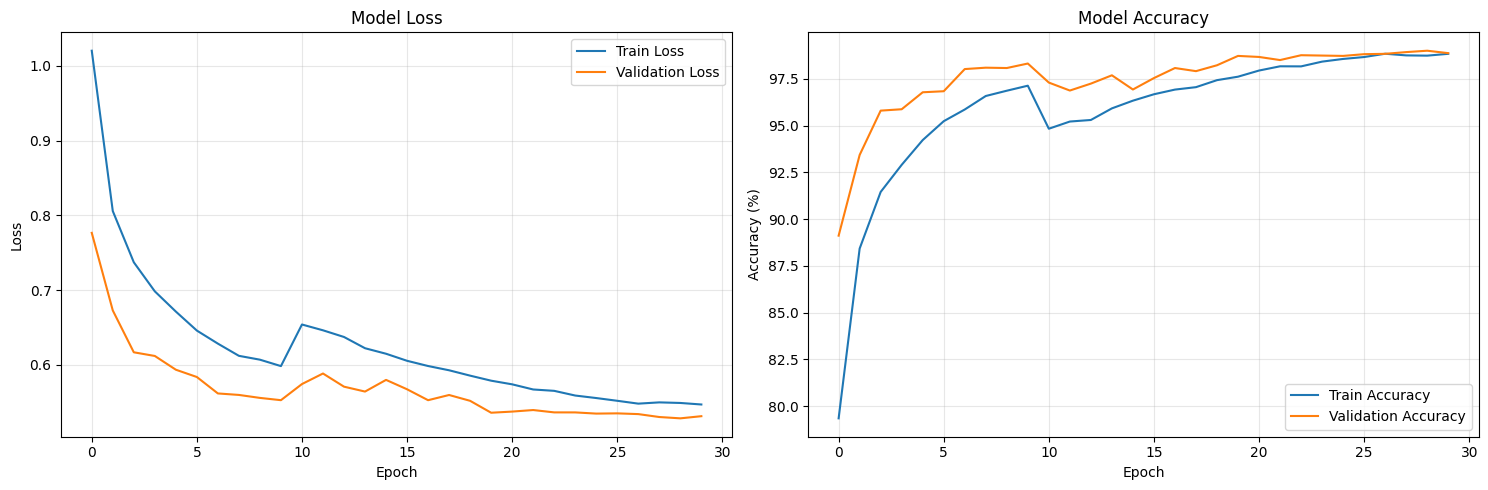

✓ Training history saved to 'training_history.png'


In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training history saved to 'training_history.png'")

## 14. Generate Test Predictions

In [58]:
# Load best model
print("Loading best model...")
checkpoint = torch.load('best_model_improved.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']+1} with val acc: {checkpoint['best_val_acc']:.2f}%")

# Generate predictions
print("\nGenerating test predictions...")
model.eval()
test_predictions = []
test_filenames = []

with torch.no_grad():
    for data, filenames in tqdm(test_loader, desc='Inference'):
        data = data.to(CONFIG['device'])
        output = model(data)
        _, predicted = torch.max(output, 1)
        test_predictions.extend(predicted.cpu().numpy())
        test_filenames.extend(filenames)

# Convert to class names
test_class_predictions = [IDX_TO_CLASS[pred] for pred in test_predictions]

print(f"\n✓ Generated {len(test_predictions)} predictions")

Loading best model...
Loaded model from epoch 29 with val acc: 99.00%

Generating test predictions...


Inference:   0%|          | 0/265 [00:00<?, ?it/s]

Loading best model...
Loaded model from epoch 29 with val acc: 99.00%

Generating test predictions...


Inference:   0%|          | 0/265 [00:00<?, ?it/s]


✓ Generated 4232 predictions


## 15. Create Submission File

In [59]:
# Create submission dataframe
submission_df = pd.DataFrame({
    'test_id': [int(os.path.basename(f).replace('test_', '').replace('.npy', '')) 
                for f in test_filenames],
    'label': test_class_predictions
})

# Sort by test_id
submission_df = submission_df.sort_values('test_id').reset_index(drop=True)

# Save
submission_df.to_csv('predictions_improved.csv', index=False)

print("✓ Submission file saved: predictions_improved.csv")
print(f"\nPrediction distribution:")
print(submission_df['label'].value_counts().sort_index())
print(f"\nFirst 10 predictions:")
print(submission_df.head(10))

✓ Submission file saved: predictions_improved.csv

Prediction distribution:
AnnualCrop              1192
Forest                    52
HerbaceousVegetation    2808
Highway                    5
Industrial               127
Pasture                    1
Residential                5
River                      8
SeaLake                   34
Name: label, dtype: int64

First 10 predictions:
   test_id                 label
0        0  HerbaceousVegetation
1        1  HerbaceousVegetation
2        2  HerbaceousVegetation
3        3  HerbaceousVegetation
4        4  HerbaceousVegetation
5        5            AnnualCrop
6        6  HerbaceousVegetation
7        7  HerbaceousVegetation
8        8  HerbaceousVegetation
9        9  HerbaceousVegetation


## 16. Validation Set Evaluation

Evaluating on validation set...


Evaluating on validation set...


Validation evaluation:   0%|          | 0/338 [00:00<?, ?it/s]

Evaluating on validation set...


Validation evaluation:   0%|          | 0/338 [00:00<?, ?it/s]


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop     0.9771    0.9950    0.9860       600
              Forest     0.9967    0.9983    0.9975       600
HerbaceousVegetation     0.9851    0.9917    0.9884       600
             Highway     0.9822    0.9920    0.9871       500
          Industrial     0.9900    0.9920    0.9910       500
             Pasture     0.9873    0.9750    0.9811       400
       PermanentCrop     0.9979    0.9720    0.9848       500
         Residential     0.9933    0.9933    0.9933       600
               River     0.9939    0.9840    0.9889       500
             SeaLake     0.9967    0.9983    0.9975       600

            accuracy                         0.9900      5400
           macro avg     0.9900    0.9892    0.9896      5400
        weighted avg     0.9901    0.9900    0.9900      5400



Evaluating on validation set...


Validation evaluation:   0%|          | 0/338 [00:00<?, ?it/s]


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop     0.9771    0.9950    0.9860       600
              Forest     0.9967    0.9983    0.9975       600
HerbaceousVegetation     0.9851    0.9917    0.9884       600
             Highway     0.9822    0.9920    0.9871       500
          Industrial     0.9900    0.9920    0.9910       500
             Pasture     0.9873    0.9750    0.9811       400
       PermanentCrop     0.9979    0.9720    0.9848       500
         Residential     0.9933    0.9933    0.9933       600
               River     0.9939    0.9840    0.9889       500
             SeaLake     0.9967    0.9983    0.9975       600

            accuracy                         0.9900      5400
           macro avg     0.9900    0.9892    0.9896      5400
        weighted avg     0.9901    0.9900    0.9900      5400



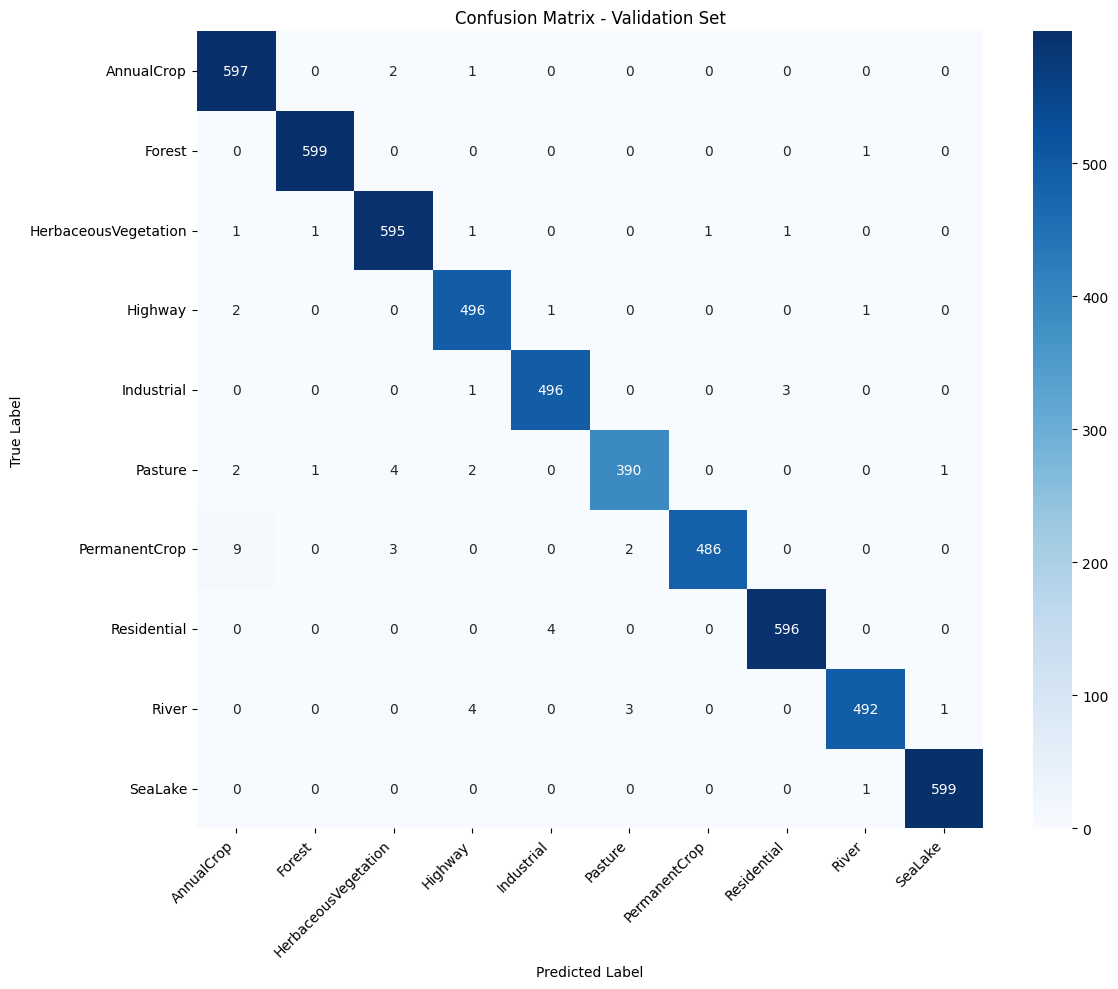

✓ Confusion matrix saved to 'confusion_matrix.png'


In [60]:
# Evaluate on validation set
print("Evaluating on validation set...")
model.eval()
val_predictions = []
val_true_labels = []

with torch.no_grad():
    for data, target in tqdm(val_loader, desc='Validation evaluation'):
        data = data.to(CONFIG['device'])
        output = model(data)
        _, predicted = torch.max(output, 1)
        val_predictions.extend(predicted.cpu().numpy())
        val_true_labels.extend(target.cpu().numpy())

# Print classification report
print("\nClassification Report:")
print(classification_report(
    val_true_labels,
    val_predictions,
    target_names=CLASSES,
    digits=4
))

# Confusion matrix
cm = confusion_matrix(val_true_labels, val_predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved to 'confusion_matrix.png'")

## Summary

This notebook implements a clean, production-ready pipeline for EuroSAT classification with:

1. **Correct Band Alignment**: Properly reorders training data from TRAIN_ORDER to TEST_ORDER
2. **Improved Model Architecture**: Residual connections and batch normalization for better performance
3. **Domain Adaptation**: Statistical normalization using training data statistics
4. **Robust Training**: Label smoothing, weight decay, gradient clipping, and early stopping
5. **Comprehensive Evaluation**: Training history plots, confusion matrix, and classification report

**Key Files Generated**:
- `best_model_improved.pth` - Best model checkpoint
- `predictions_improved.csv` - Test set predictions
- `training_history.png` - Training curves
- `confusion_matrix.png` - Validation confusion matrix